# Why expressions classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

In [2]:
codestral_classification_data_file_name = "./cme_codestral-latest_classification.csv"

The following dataset contains the answers of the model to the prompts to classify the category of the "Why" and "What" expression/

In [3]:
codestral_classification = pd.read_csv(codestral_classification_data_file_name)
codestral_classification.head()

,url,message,api_url,diff,why_category,why_category_expl,what_category,what_category_expl
0,https://github.com/junit-team/junit4/commit/31...,Relicense JUnit from CPL to EPL <enter> EPL i...,https://api.github.com/repos/junit-team/junit4...,"@@ -1,8 +1,8 @@\n JUnit\n \n-Common Public Lic...",Describe Objective,The commit message explains the objective of t...,Summarize Code Object Change,The commit message primarily describes the cha...
1,https://github.com/spring-projects/spring-boot...,Better diagnotics when ESCF subclass breaks wi...,https://api.github.com/repos/spring-projects/s...,"@@ -17,6 +17,7 @@\n package org.springframewor...",Describe Issue,The commit message describes the issue of fail...,Describe Implementation Principle,The commit message explains the technical prin...
2,https://github.com/spring-projects/spring-boot...,Update view of bean types when an override is ...,https://api.github.com/repos/spring-projects/s...,"@@ -76,7 +76,7 @@ final class BeanTypeRegistry...",Describe Issue,The commit message directly elaborates the mot...,Summarize Code Object Change,The commit message summarizes the changes in t...
3,https://github.com/square/okhttp/commit/868ee8...,Drop our one remaining DSS cipher suite. <ent...,https://api.github.com/repos/square/okhttp/com...,"@@ -37,7 +37,7 @@\n */\n public final class C...",Describe Issue,The commit message directly elaborates the mot...,Summarize Code Object Change,The commit message summarizes the code object ...
4,https://github.com/spring-projects/spring-boot...,Fix undertow access_log file name <enter> Und...,https://api.github.com/repos/spring-projects/s...,"@@ -384,7 +384,7 @@ private AccessLogHandler c...",Describe Issue,The commit message directly elaborates the mot...,Summarize Code Object Change,The commit message summarizes the code object ...


In [4]:
n_codestral_classification = codestral_classification['why_category'].notna().sum()
print(f'The model categorize {n_codestral_classification} of {len(codestral_classification)} commit messages')

The model categorize 264 of 271 commit messages


In [5]:
codestral_classification['why_category'].value_counts()

why_category
Describe Issue            166
Describe Objective         54
Ilustrate Requirement      19
Describe Requirement       12
Illustrate Requirement     10
Missing Why                 2
Imply necessity             1
Name: count, dtype: int64

Uniformizamos los datos por errores de typeo

In [6]:
codestral_classification['why_category'] = codestral_classification['why_category'].replace('Ilustrate Requirement', 'Illustrate Requirement')
codestral_classification['why_category'] = codestral_classification['why_category'].replace('Describe Requirement', 'Illustrate Requirement')
codestral_classification['why_category'].value_counts()

why_category
Describe Issue            166
Describe Objective         54
Illustrate Requirement     41
Missing Why                 2
Imply necessity             1
Name: count, dtype: int64

**Loading the manually labeled dataset (ground truth classification)**

In [7]:
manually_classification = pd.read_excel('../data/maintenance type and expression way.xlsx')

In [8]:
manually_classification.head()

,Commit ID,URL,Commit Message,Commit Type,Why Codes,Why Initial Category,Why Subcategory,Why Category,What Codes,What Initial Category,What Subcategory,What Category
0,S257,https://github.com/junit-team/junit4/commit/31...,Relicense JUnit from CPL to EPL <enter> EPL i...,Adaptive,EPL is the successor version of the CPL; CPL i...,bug/defect scenario,Describe error scenario,Describe issue,Relicense JUnit from CPL to EPL,Summarize the key changes,Object of change,Summarize code change
1,S258,https://github.com/spring-projects/spring-boot...,Better diagnotics when ESCF subclass breaks wi...,Corrective,This commit improves the diagnostics so that,Bug/Defect scenario,Describe error scenario,Describe issue,This commit improves the diagnostics; fail fa...,Summarize of function change,Illustrate function,Illustrate function
2,S259,https://github.com/spring-projects/spring-boot...,Update view of bean types when an override is ...,Corrective,This would lead to incorrect,Bug/Defect scenario,Describe error scenario,Describe issue,Update view of bean types when an override is ...,summarize code change and illustrate function,Contrast before and after& \nIllustrate function,Illustrate function& Summarize code change
3,S206,https://github.com/square/okhttp/commit/868ee8...,Drop our one remaining DSS cipher suite. <ent...,Perfective,"Tracking Chrome and Firefox, which have also d...",Change based on standards,Conventions and standards,Imply necessity,Drop our one remaining DSS cipher suite.,summarize code change,Object of change,Summarize code change
4,S173,https://github.com/spring-projects/spring-boot...,Fix undertow access_log file name <enter> Und...,Corrective,Undertow 1.3.2 changed the default access log...,Change because the environment change,Runtime or development environment change,Illustrate requirement,adapt the file name pattern to include the mi...,Describe the status of code object before and ...,Contrast before and after,Summarize code change


In [9]:
manually_classification['Why Category'] = manually_classification['Why Category'].replace('Illustrate requirement', 'Illustrate Requirement')
manually_classification['Why Category'] = manually_classification['Why Category'].replace('Describe objective', 'Describe Objective')
manually_classification['Why Category'] = manually_classification['Why Category'].replace('Describe issue', 'Describe Issue')

In [10]:
considered_values = ['Describe Issue', 'Describe Objective', 'Illustrate Requirement', 'Missing Why', 'Imply necessity']
considered_values_idx = manually_classification[manually_classification['Why Category'].isin(considered_values)].index
print(f'We are considering just {len(considered_values_idx)} of the {len(manually_classification)} commit messages')

We are considering just 246 of the 271 commit messages


In [11]:
codestral_classification.loc[considered_values_idx].shape

(246, 8)

In [12]:
codestral_classification_considered = codestral_classification.loc[considered_values_idx]
final_considered_values_idx = codestral_classification_considered[codestral_classification_considered['why_category'].notna()].index

In [13]:
human_classification_why = manually_classification.loc[final_considered_values_idx]['Why Category']
human_classification_why

0              Describe Issue
1              Describe Issue
2              Describe Issue
3             Imply necessity
4      Illustrate Requirement
                ...          
247           Imply necessity
248               Missing Why
249           Imply necessity
250           Imply necessity
251           Imply necessity
Name: Why Category, Length: 239, dtype: object

In [14]:
codestral_predictions_why = codestral_classification.loc[final_considered_values_idx]['why_category']
codestral_predictions_why

0      Describe Objective
1          Describe Issue
2          Describe Issue
3          Describe Issue
4          Describe Issue
              ...        
247       Imply necessity
248        Describe Issue
249    Describe Objective
250    Describe Objective
251           Missing Why
Name: why_category, Length: 239, dtype: object

In [15]:
cohen_kappa_score(human_classification_why, codestral_predictions_why)

0.1062636335306949

In [16]:
cm = confusion_matrix(human_classification_why, codestral_predictions_why, labels=considered_values)

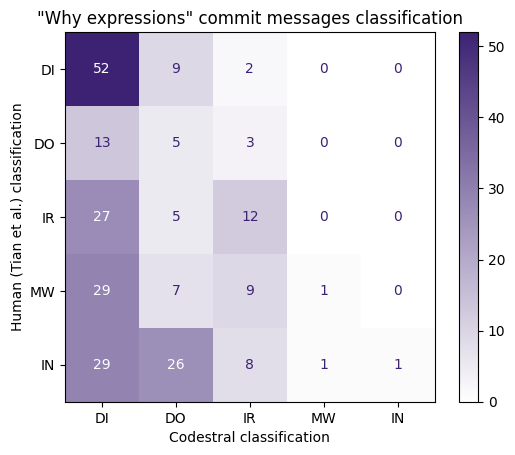

In [17]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['DI', 'DO', 'IR', 'MW', 'IN'])
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","#3D2273"])
cm_display.plot(cmap=cmap)
plt.ylabel('Human (Tian et al.) classification')
plt.xlabel('Codestral classification')
plt.title('"Why expressions" commit messages classification')
plt.show()

In [18]:
class_rep_dict = classification_report(human_classification_why,codestral_predictions_why, output_dict=True)
class_rep_dict['Average (weighted)'] = class_rep_dict.pop('weighted avg')
class_rep_dict.pop('accuracy')
class_rep_dict.pop('macro avg')

{'precision': 0.45915233785822024,
 'recall': 0.27466861640774687,
 'f1-score': 0.20098224336599796,
 'support': 239.0}

In [19]:
class_rep_df = pd.DataFrame(class_rep_dict).transpose()
class_rep_df

,precision,recall,f1-score,support
Describe Issue,0.346667,0.825397,0.488263,63.0
Describe Objective,0.096154,0.238095,0.136986,21.0
Illustrate Requirement,0.352941,0.272727,0.307692,44.0
Imply necessity,1.000000,0.015385,0.030303,65.0
Missing Why,0.500000,0.021739,0.041667,46.0
Average (weighted),0.533007,0.297071,0.213649,239.0


In [20]:
class_rep_df.to_latex('why_expressions_eclassification_metrics.tex', float_format="%.2f")